# Word-Embedding Recurrent Model

Using the balanced data.

Set whether the model looks at abstracts or titles here:

In [22]:
# 'abstract' or 'title'
text_field = 'abstract'
assert text_field in ('abstract', 'title'), 'text_field must be one of title or abstract.'

# Imports and Setup

Imports and colab setup

In [23]:
%%capture import_capture --no-stder
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# pip installs needed in Colababstract for arxiv_vixra_models
!pip install wandb --upgrade
# v1.5.0 of pl breaks wandb sweeps:
# https://github.com/PyTorchLightning/pytorch-lightning/issues/10336
!pip install pytorch-lightning==1.4.9
!pip install unidecode
# Update sklearn
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

import math
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
pd.set_option(u'float_format', '{:f}'.format)

# pl and wandb installation and setup.
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
import wandb

`wandb` log in:

In [24]:
wandb.login()

True

Google drive access

In [25]:
# Give the notebook access to the rest of your google drive files.
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing modules stored in FOLDERNAME or a subdirectory thereof:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


Import models, loaders, and utility functions from an external package:

In [26]:
import arxiv_vixra_models as avm

Computing specs. Save the number of processors to pass as `num_workers` into the Datamodule and cuda availability for other flags.

In [27]:
# GPU. Save availability to is_cuda_available.
gpu_info= !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  is_cuda_available = False
else:
  print(f"GPU\n{50 * '-'}\n", gpu_info, '\n')
  is_cuda_available = True

# Memory.
from psutil import virtual_memory, cpu_count
ram_gb = virtual_memory().total / 1e9
print(f"Memory\n{50 * '-'}\n", 'Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb), '\n')

# CPU.
print(f"CPU\n{50 * '-'}\n",f'CPU Processors: {cpu_count()}')
# Determine the number of workers to use in the datamodule
num_processors = cpu_count()

GPU
--------------------------------------------------
 Tue Nov 16 03:47:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    41W / 300W |   3481MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                

Copy data to cwd for speed.

In [28]:
train_data_file_name = 'balanced_filtered_normalized_data_train.feather'
val_data_file_name = 'balanced_filtered_normalized_data_validation.feather'
SUBDIR = '/data/data_splits/'
train_data_path = FOLDERNAME + SUBDIR + train_data_file_name
val_data_path = FOLDERNAME + SUBDIR + val_data_file_name
vocab_file_name = 'balanced_abstract_normalized_vocab.feather' if text_field == 'abstract' else 'balanced_title_normalized_vocab.feather'
vocab_path = FOLDERNAME + SUBDIR + vocab_file_name
!cp '{train_data_path}' .
!cp '{val_data_path}' .
!cp '{vocab_path}' .

In [29]:
train_data_df = pd.read_feather(train_data_file_name)
val_data_df = pd.read_feather(val_data_file_name)
vocab_df = pd.read_feather(vocab_file_name)

Use notebook name as `wandb` `project` string. Remove the file extension and any "Copy of" or "Kopie van" text which arises from copying notebooks and running in parallel.

In [30]:
from requests import get
project_str = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
project_str = project_str.replace('.ipynb', '').replace('Kopie%20van%20', '').replace('Copy%20of%20', '')
print(project_str)

balanced_abstract_embedding_recurrent


# Validation Set Filtering

Filter any overlap between the training and validation datasets. Most complete duplicates should have been filtered, but some may not have evaluated as equal prior to text normalization or because they only coinicided in one of the two text columns (e.g., there are distinct papers which share the same title but have different abstracts in the dataset).  We perform strict filtering below.

In [31]:
val_data_intersections_filtered_df = val_data_df.merge(train_data_df, on=[text_field], how='outer', suffixes=['', '_'], indicator=True).loc[lambda x: x['_merge'] == 'left_only'].iloc[:,:3]
print(f'{len(val_data_df) - len(val_data_intersections_filtered_df)} items removed from val set, {100 * (len(val_data_df) - len(val_data_intersections_filtered_df)) / len(val_data_df):.3f} percent.')

62 items removed from val set, 0.823 percent.


Inspect datasets using `print` and `to_string()` to avoid colab javascript errors

In [32]:
print(train_data_df.head().to_string())

                                                                                         title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [33]:
print(val_data_intersections_filtered_df.head().to_string())

                                                                                 title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    abstract source
0                             

# Model Testing

Setting hyperparameters and performing a small test run.

Dictionary args for model and datamodule.

In [34]:
# Raw was prepared with a max of 256 words for abstracts and 16 for titles.
# The insertion of spaces around punctuation increases the effective word count,
# and exploration shows that nearly all of the data is captured by increasing
# the seq_len by 50%.
seq_len = int(1.5 * 256) if text_field == 'abstract' else int(1.5 * 16)
model_args_dic = {'seq_len': seq_len,
              'num_layers': 3,
              'bidirectional': True,
              'rnn_type': 'GRU',
              'hidden_size': 128,
              'vocab': vocab_df,
              }
              
data_args_dic = {'seq_len': seq_len,
                 'train_data': train_data_df,
                 'val_data': val_data_intersections_filtered_df,
                 'vocab': vocab_df, 
                 'text_column': text_field,
                 'num_workers': num_processors,
                 'batch_size': 512,
                 'pin_memory': False,
                 'persistent_workers': True
                 }

Small test run.

In [36]:
small_example_data_module = avm.EmbeddingDataModule(**{**data_args_dic, **{'sample_size': data_args_dic['batch_size']}})
small_example_data_module.setup()
small_example_loader = small_example_data_module.train_dataloader()
small_example_inputs, small_example_targets = next(iter(small_example_loader))
# Print the first few input texts
for tensor, source in zip(small_example_inputs[:3], small_example_targets[:3]):
    stripped_text = avm.ints_to_string(tensor, vocab_df)
    print(f"text: {stripped_text}",
          f'len: {len(stripped_text)}',
          f'source: {source.item()}',
          sep='\n')
small_example_model = avm.LitEmbeddingRecurrent(**model_args_dic)
small_example_preds, small_example_losses, _ = small_example_model.preds_losses_hiddens(small_example_inputs, small_example_targets)
print('\npreds shape:', small_example_preds.shape, '\n')
print('\nactual loss:', small_example_losses.item(), '\n')
print('\nexpected approx loss', -math.log(.5), '\n')

text: let $ \ mathbb f _ q $ be a finite field with $ q $ elements , where $ q $ is an odd prime power . in this paper we associated circulant matrices and quadratic forms with curves of artin - schreier $ y ^ q - y = x \ cdot p ( x ) - \ lambda , $ where $ p ( x ) $ is a $ \ mathbb f _ q $ - linearized polynomial and $ \ lambda \ in \ mathbb f _ q $ . our main results provide a characterization of the number of rational points in some extension $ \ mathbb f _ { q ^ r } $ of $ \ mathbb f _ q $ . in the particular case , in the case when $ p ( x ) = x ^ { q ^ i } - x $ we given a full description of the number of rational points in term of legendre symbol and quadratic characters .
len: 683
source: 0.0
text: weak - signal detection and single - particle selection from low - contrast micrographs of frozen hydrated biomolecules by cryo - electron microscopy ( cryo - em ) presents a practical challenge . cryo - em image contrast degrades as the size of biomolecules of structural interest d

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



preds shape: torch.Size([512]) 


actual loss: 0.6918372511863708 


expected approx loss 0.6931471805599453 



In [ ]:
small_example_trainer = Trainer(gpus=-1,
                                max_epochs=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
small_example_trainer.fit(small_example_model,
                          datamodule=small_example_data_module
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                    | Type             | Params
--------------------------------------------------------------
0  | train_acc               | Accuracy         | 0     
1  | val_acc                 | Accuracy         | 0     
2  | test_acc                | Accuracy      

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:327: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


# `wandb` Hyperparameter Tuning



Set fixed hyperparameters and the configuration file for the `wandb` sweep.  Notes on the setup below:
* In `sweep_config['parameters']` we only include those parameters which are to be swept over.
* All fixed parameters will put in `fixed_hyperparam_dic`.
* `fixed_hyperparam_dic` is eventually merged with the hyperparameter dictionary for those hyperparameters included in `sweep_config` which is generated by `wandb`, with the result passed to the model.
* It is simplest to only sweep over hyperparameters which don't change the size of the model so that we can optimize with a single `batch_size`.  This also helps prevent `CUDA` memory errors which can occur if the sweep generates a model which is too large for the given `batch_size`.
* Pass a `count: int` arg to `wandb.agent` to limit the number of models trained. Without, the training runs indefinitely.

For models with an embedding layer, there is also a choice to be made about vocabulary size.  The `vocab_df` has a `counts` column, indicated how many times a given word appears in the training set.  It is natural to set some threshold by `count` for which words to include in the vocab set. Setting a threshold both reduces the vocab size and increases the proportion of words which will 

Text(0, 0.5, 'total words percent removed')

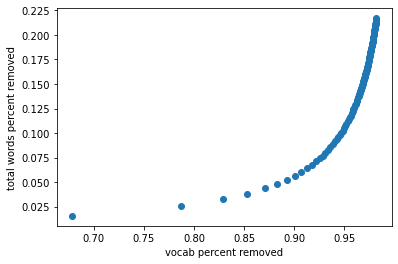

In [ ]:
def vocab_words_removed(n, df):
    df = df.copy()
    filtered_df = df.loc[lambda x: x['count'] >= n]
    vocab_removed = 1- len(filtered_df) / len(df)
    words_removed = 1 - filtered_df['count'].sum() / df['count'].sum()
    return (vocab_removed, words_removed)

removed_data = [vocab_words_removed(5 * n, vocab_df) for n in range(1, 100)]
fig, ax = plt.subplots(1, 1)
ax.scatter(*zip(*removed_data))
ax.set_xlabel('vocab percent removed')
ax.set_ylabel('total words percent removed')

Include `min_word_count` in the hyperparameters, which sets the vocab size. The `vocab` `DataFrame` passed to the datamodule and architecture are dynamicaly set in the `sweep_iteration` function below.

In [ ]:
fixed_hyperparam_dic = {'seq_len': seq_len,
                        'rnn_type': 'GRU',
                        'num_layers': 2,
                        'bidirectional': True,
                        'hidden_size': 128,
                        'embedding_dim': 256,
                        'truncated_bptt_steps': None,
                        'input_dropout': None,
                        'fc_dropout': None,
                        'recurrent_dropout': None,
                        'min_word_count': 32
                        }
# fixed_hyperparam_dic will be overwritten with entries
# provided to sweep_config
sweep_config = {'method': 'random'}
sweep_config['early_terminate'] = {'type': 'hyperband',
                                    'min_iter': 5
                                   }
sweep_config['metric'] = {'name': 'best_val_loss',
                           'goal': 'minimize'
                           }
sweep_config['parameters'] =  {'lr': {'distribution': 'log_uniform',
                                      'min': math.log(1e-4),
                                      'max': math.log(1e-2)
                                      },
                               'input_dropout': {'distribution': 'uniform',
                                      'min': .25,
                                      'max': .6,
                                      },

                               'fc_dropout': {'distribution': 'uniform',
                                      'min': .25,
                                      'max': .6,
                                      },
                               }

Re-instantiate data using the full dataset and a non-trivial batch size.  Implement truncated backpropagation through time, if desired, and set the `max_epochs` of the run and other desired parameters in dictionary for the trainer, which is also appended to `fixed_hyperparam_dic` for logging purposes.

In [ ]:
# Setting 'batch_size' in data_args_dic controls the batch size, while setting
# this key in fixed_hyperparam_dic just lets wandb track this hyperparameter.
data_args_dic['batch_size'] = fixed_hyperparam_dic['batch_size'] = 512 #2 **10

# Set max_epochs in a dict, along with any other optional trainer kwargs.
trainer_dic = {'max_epochs': 8,
               'stochastic_weight_avg': True
               }
# Merge trainer_dic into fixed_hyperparam_dic for logging purposes.
fixed_hyperparam_dic = {**fixed_hyperparam_dic, **trainer_dic}

def sweep_iteration():
    # Group by various properties
    group_str_elements = [fixed_hyperparam_dic['rnn_type'],
                          f"{'-bidirectional' if fixed_hyperparam_dic['bidirectional'] else ''}",
                          f"-hidden_size_{fixed_hyperparam_dic['hidden_size']}",
                          f"-{fixed_hyperparam_dic['num_layers']}_layers",
                          f"-{fixed_hyperparam_dic['max_epochs']}_epochs"]
    group_str = ''.join(group_str_elements)
    with wandb.init(group=group_str) as run:
        config = wandb.config
        # Merge config into remaining parameters.
        config = {**fixed_hyperparam_dic, **config}
        # Generated new vocab df based on min_word_count_filter
        filtered_vocab_df = vocab_df.loc[lambda x: x['count'] >= config['min_word_count']].copy()
        config['vocab'] = filtered_vocab_df
        data_args_dic['vocab'] = filtered_vocab_df
        data = avm.EmbeddingDataModule(**data_args_dic)
        model = avm.LitEmbeddingRecurrent(**config)
        # Taking random samples from the validation set for callback visualization.
        val_sample_module = avm.EmbeddingDataModule(**{**data_args_dic, **{'sample_size': 512}})
        val_sample_module.setup()
        val_sample  = next(iter(val_sample_module.val_dataloader()))
        # Overwrite the random run names chosen by wandb.
        name_str_elements = [f"lr_{config['lr']:.3E}",
                             f"{'-fc_dropout_' + str(config['fc_dropout']) if config['fc_dropout'] else ''}",
                             f"{'recurrent_-dropout_' + str(config['recurrent_dropout']) if config['recurrent_dropout'] else ''}",
                             f"-embedding_dim_{config['embedding_dim']}"]
        name_str = ''.join(name_str_elements)
        run.name = name_str
        trainer = Trainer(
            logger=WandbLogger(),
            gpus=-1 if is_cuda_available else 0,
            log_every_n_steps=5,
            callbacks=[avm.WandbTextCallback(val_sample=val_sample,
                                             decoder_fn=avm.ints_to_string,
                                             translation_data=vocab_df,
                                             labels=('arxiv', 'vixra'))],
            num_sanity_val_steps=-1,
            **trainer_dic
            )
        trainer.fit(model, datamodule=data)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project=project_str)

Create sweep with ID: 5k4o1l7z
Sweep URL: https://wandb.ai/garrett361/balanced_abstract_embedding_recurrent/sweeps/5k4o1l7z


In [ ]:
wandb.agent(sweep_id, function=sweep_iteration)